In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv1D,Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape,GRU
from keras.utils import to_categorical
import matplotlib.pyplot as plt

(2115, 22, 1000)
(443, 22, 1000)


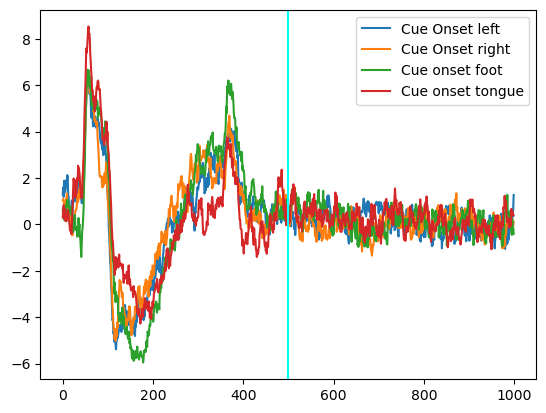

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
print(X_test.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 
# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]

class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)

class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')
plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])


In [3]:
def train_data_prep(X,y,sub_sample,average,noise): # preparation for training samples - Subsampling, Averaging, Noise - data augmentation
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800] # downsampling is equivalent to LPF because Nyquist
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3) # LPF (mean-pooling)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape) # noise for regularization
    
    total_X = np.vstack((total_X, X_average)) # 2100 samples -> 4200 samples (data augmentation)
    total_y = np.hstack((total_y, y))

    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X): # prep the test data
    
    total_X = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [4]:

## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True) #train and validation data
print('Test data prep')
X_test_prep = test_data_prep(X_test) # this is fine, no data leakage

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(X_train_valid.shape[0], X_train_valid.shape[0]//5, replace=False) #5-fold cross validation...?
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
print('Training and testing split')
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

## Random splitting and reshaping the data
# data leakage
# should split into train/val AND THEN do data augmentation
# otherwise we get correlation between training and validation data (model already knows the label from the training)
print('Training data prep')
x_train, y_train = train_data_prep(x_train,y_train,2,2,False) # these are now x_train_prep and y_train_prep
print('Validation data prep')
x_valid, y_valid = train_data_prep(x_valid,y_valid,2,2,False)

print('Categorical conversion (one-hot encoding)')
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

print('Reshaping the data (add width of 1)')
# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


print('Reshaping the data (swap axes)')
# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Test data prep
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Training and testing split
Shape of training set: (1692, 22, 1000)
Shape of validation set: (423, 22, 1000)
Shape of training labels: (1692,)
Shape of validation labels: (423,)
Training data prep
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Validation data prep
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of X after averaging+noise and concatenating: (846, 22, 400)
Shape of X after subsampling and concatenating: (1692, 22, 400)
Shape of Y: (1692,)
Categorical conversion (one-hot encoding)
Shape of training labels after categorical conversion: (6768, 4)
Shape of validation labels after categorical conversion: (1692, 4)
Shape of test labels after cate

In [5]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

uniform_kernel_size = (3,3)
uniform_pool_size = (3,1) # originally 3,1
uniform_dropout = 0.5
# Conv. block 1 (batch_shape, steps, channels)
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(2,2), padding='same', activation='elu', input_shape=(400, 1, 22))) #(400,1,22)
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=uniform_pool_size, padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(uniform_dropout))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=uniform_kernel_size, padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=uniform_pool_size, padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(uniform_dropout))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=uniform_kernel_size, padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=uniform_pool_size, padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(uniform_dropout))

# Conv. block 4
# hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(4,4), padding='same', activation='elu'))
# hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=uniform_pool_size, padding='same')) # input shape: (batch_size, height, width, channels), output shape: (batch_size, pooled_height, pooled_width, channels)
# hybrid_cnn_lstm_model.add(BatchNormalization())
# hybrid_cnn_lstm_model.add(Dropout(uniform_dropout))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
# hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
# hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
# hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False)) # LSTM layer with 10 units
#input shape: (batch, timesteps, feature)
 
# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 1, 25)        2225      
                                                                 
 max_pooling2d (MaxPooling2  (None, 134, 1, 25)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 134, 1, 25)        100       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 134, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 134, 1, 50)        11300     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 1, 50)         0

In [6]:
# Model parameters
learning_rate = 1e-3
epochs = 50
hybrid_cnn_lstm_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [7]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])
print("X train shape")
print(x_train.shape)
print("Y train shape")
print(y_train.shape)
# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)




X train shape
(6768, 400, 1, 22)
Y train shape
(6768, 4)
Epoch 1/50
106/106 [==============================] - 2s 13ms/step - loss: 1.8902 - accuracy: 0.3369 - val_loss: 1.2457 - val_accuracy: 0.4054
Epoch 2/50
106/106 [==============================] - 1s 13ms/step - loss: 1.4603 - accuracy: 0.4282 - val_loss: 1.1708 - val_accuracy: 0.4770
Epoch 3/50
106/106 [==============================] - 1s 13ms/step - loss: 1.2990 - accuracy: 0.4663 - val_loss: 1.1021 - val_accuracy: 0.5177
Epoch 4/50
106/106 [==============================] - 1s 13ms/step - loss: 1.1466 - accuracy: 0.5273 - val_loss: 1.0729 - val_accuracy: 0.5171
Epoch 5/50
106/106 [==============================] - 1s 13ms/step - loss: 1.0925 - accuracy: 0.5434 - val_loss: 0.9736 - val_accuracy: 0.6164
Epoch 6/50
106/106 [==============================] - 1s 13ms/step - loss: 1.0342 - accuracy: 0.5739 - val_loss: 0.9600 - val_accuracy: 0.6170
Epoch 7/50
106/106 [==============================] - 1s 13ms/step - loss: 0.9867 - a

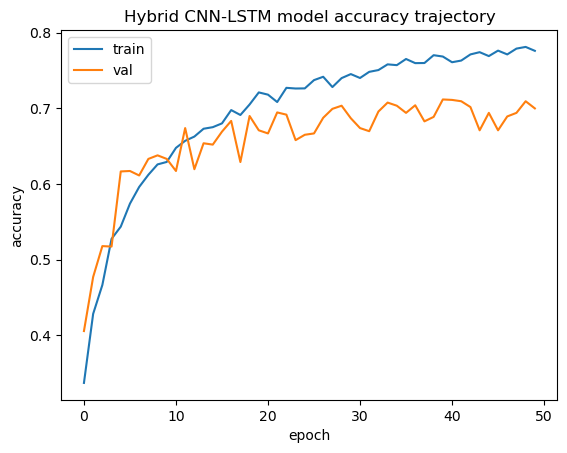

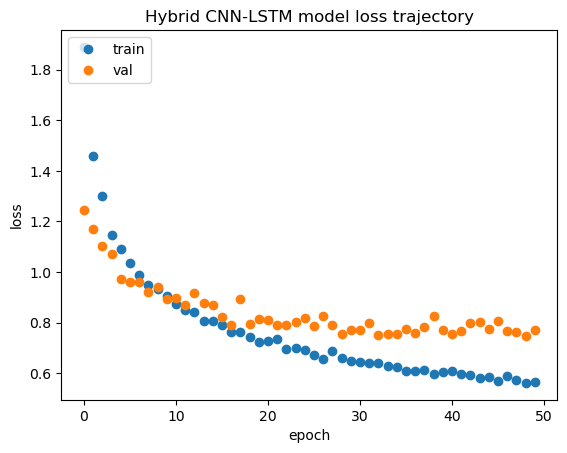

In [8]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# data leakage
# should split into train/val AND THEN do data augmentation
# otherwise we get correlation between training and validation data (model already knows the label from the training)

In [9]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7088035941123962


In [10]:
# Adjacency matrix (correlations between channels) -> CNN
# pearson correlation coefficients